In [1]:
import mpmath
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import eval_genlaguerre, loggamma
from mpmath import jtheta,sqrt, exp, pi, conj
import csv
from scipy.sparse.linalg import expm
from scipy.linalg import eigvalsh

In [2]:
# calculates the Siegel theta function from Jacobis
def siegel(z1,z2):
    return(sqrt(2)*exp(-pi*z1*z1-pi*z2*z2+2j*pi*z1*z2)* \
    jtheta(3,pi*(1.0j*z1+z2),exp(-pi))*jtheta(3,pi*(z1+1.0j*z2),exp(-pi)))

# get the phase e^{\xi_q(k)}
def getPhase(kvec,qvec,latticeVec1,latticeVec2):
    k1 = np.dot(kvec,latticeVec1)
    k2 = np.dot(kvec,latticeVec2)
    q1 = np.dot(qvec,latticeVec1)
    q2 = np.dot(qvec,latticeVec2)
    
    qComplex = q1 + 1.0j*q2
    numer = exp(-qComplex*conj(qComplex)/(8*pi))*siegel((k1-qComplex/2)/(2*pi),(k2+1.0j*qComplex/2)/(2*pi))
    denom= sqrt(siegel(k1/(2*pi),k2/(2*pi))*siegel((k1-q1)/(2*pi),(k2-q2)/(2*pi)))
    return(complex(numer/denom))

In [62]:
p = 1
q = 1
phi = (2*np.pi*p)/q
w0 = 0.8/np.sqrt(3) 
w1 = 1.0/np.sqrt(3)
vfkth = 110*np.sqrt(3)

In [63]:
a1 = 2./3*np.array([-np.sqrt(3)/2, -1./2],dtype=complex);
a2 = 2./3*np.array([np.sqrt(3)/2, -1./2],dtype=complex);
b1 = np.array([-np.sqrt(3)/2, -3./2],dtype=complex);
b2 = np.array([np.sqrt(3)/2, -3./2],dtype=complex);

ta1 = 1.0/p*a1
ta2 = q*a2
tb1 = p*b1
tb2 = 1.0/q*b2

s2 = np.array([[0, -1.0j], [1.0j, 0]],dtype=complex)
t1 = np.array([[w0, w1], [w1, w0]],dtype=complex)
t2 = np.array([[w0, w1*np.exp(-2j*np.pi/3)], [w1*np.exp(2j*np.pi/3), w0]],dtype=complex)
t3 = np.array([[w0, w1*np.exp(2j*np.pi/3)], [w1*np.exp(-2j*np.pi/3), w0]],dtype=complex)

In [64]:
omega = ta1[0]*ta2[1] - ta1[1]*ta2[0]
z1 = 1/np.sqrt(omega)*(ta1[0]+1.0j*ta1[1])
z2 = 1/np.sqrt(omega)*(ta2[0]+1.0j*ta2[1])

In [65]:
qvec = 2*np.pi*b1
gQ = np.dot(qvec,ta1)*np.conj(z2)-np.dot(qvec,ta2)*np.conj(z1)
gQbar = np.conj(gQ)

num_landau_calc = 200
num_landau = 100

toExp = np.zeros((num_landau_calc,num_landau_calc),dtype=complex)

for m in range(num_landau_calc-1):
    toExp[m,m+1] = np.sqrt(m+1)*1.0j*gQ/np.sqrt(4*np.pi)
    toExp[m+1,m] = np.sqrt(m+1)*1.0j*gQbar/np.sqrt(4*np.pi)
    
formFactors1 = expm(toExp)

qvec = 2*np.pi*b2
gQ = np.dot(qvec,ta1)*np.conj(z2)-np.dot(qvec,ta2)*np.conj(z1)
gQbar = np.conj(gQ)

toExp2 = np.zeros((num_landau_calc,num_landau_calc),dtype=complex)

for m in range(num_landau_calc-1):
    toExp2[m,m+1] = np.sqrt(m+1)*1.0j*gQ/np.sqrt(4*np.pi)
    toExp2[m+1,m] = np.sqrt(m+1)*1.0j*gQbar/np.sqrt(4*np.pi)
    
formFactors2 = expm(toExp2)

In [66]:
formFactors2[1][2]

(-0.17868533624635444-0.3094920809462145j)

In [67]:
energy = np.sqrt(phi/(2*np.pi))* np.sqrt((3*np.sqrt(3))/(2*np.pi))
kinetic_1 = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex) # layer 1
kinetic_2 = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex) # layer 2

# First we add the kinetic terms
for m in range(-num_landau,num_landau+1): 
    kinetic_1[m][m] = energy * np.sqrt(abs(m)) *np.sign(m)
    kinetic_2[m][m] = energy * np.sqrt(abs(m)) *np.sign(m)

# And then the shifts from the change of basis    
for m in range(-num_landau,num_landau+1):
    for n in range(-num_landau,num_landau+1):
        if (abs(m)-1 == abs(n)):
            coeff = 1.0/((np.sqrt(2))**(np.sign(abs(n)) + np.sign(abs(m))))
            kinetic_2[m][n] = 0.5j*np.sign(m)*coeff
            kinetic_1[m][n] = -0.5j*np.sign(m)*coeff
        elif (abs(m) == abs(n)-1):
            coeff = 1.0/((np.sqrt(2))**(np.sign(abs(n)) + np.sign(abs(m))))
            kinetic_2[m][n] = -0.5j*np.sign(n)*coeff
            kinetic_1[m][n] = 0.5j*np.sign(n)*coeff

In [68]:
# now the T-matrices, but the k-dependence is factored out
t1_matrix = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
t2_matrix = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
t3_matrix = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)

for m in range(-num_landau,num_landau+1):
    for n in range(-num_landau,num_landau+1):            
        coe = 1.0/((np.sqrt(2))**(np.sign(abs(n)) + np.sign(abs(m))))
            
        t2_matrix[m][n] += coe*w0*formFactors1[abs(m),abs(n)]
        t3_matrix[m][n] += coe*w0*formFactors2[abs(m),abs(n)]
            
        if abs(n) > 0 and abs(m) > 0:
            t2_matrix[m][n] += np.sign(m*n)*coe*w0*formFactors1[abs(m)-1,abs(n)-1]
            t3_matrix[m][n] += np.sign(m*n)*coe*w0*formFactors2[abs(m)-1,abs(n)-1]

        if abs(n) > 0:
            t2_matrix[m][n] += np.sign(n)*coe*w1*np.exp(-2.0j*np.pi/3)*formFactors1[abs(m),abs(n)-1]
            t3_matrix[m][n] += np.sign(n)*coe*w1*np.exp(2.0j*np.pi/3)*formFactors2[abs(m),abs(n)-1]

        if abs(m) > 0:
            t2_matrix[m][n] += np.sign(m)*coe*w1*np.exp(2.0j*np.pi/3)*formFactors1[abs(m)-1,abs(n)]
            t3_matrix[m][n] += np.sign(m)*coe*w1*np.exp(-2.0j*np.pi/3)*formFactors2[abs(m)-1,abs(n)]

        if abs(m) == abs(n):
            t1_matrix[m][n] += w0*coe
            if abs(m) != 0:
                t1_matrix[m][n] += w0*coe*np.sign(m*n)
                    
        if abs(m)-1 == abs(n) and abs(m) != 0:
            t1_matrix[m][n] += w1*coe*np.sign(m)
                
        if abs(n)-1 == abs(m) and abs(n) != 0:
            t1_matrix[m][n] += w1*coe*np.sign(n)

In [69]:
def generateHamiltonian(kvec):
    
    
    diagKinetic1 = [[np.zeros((2*num_landau+1,2*num_landau+1),dtype='complex') for v in range(p)] for u in range(p)]
    diagKinetic2 = [[np.zeros((2*num_landau+1,2*num_landau+1),dtype='complex') for v in range(p)] for u in range(p)]
    
    diagPotential = [[np.zeros((2*num_landau+1,2*num_landau+1),dtype='complex') for v in range(p)] for u in range(p)]
    offDiagPotential = [[np.zeros((2*num_landau+1,2*num_landau+1),dtype='complex') for v in range(p)] for u in range(p)]

    for v in range(p):
        diagKinetic1[v][v] = kinetic_1
        diagKinetic2[v][v] = kinetic_2
        
        diagPotential[v][v] = t1_matrix+getPhase(kvec+2*np.pi*b1*v,2*np.pi*b2,ta1,ta2)*t3_matrix 
        # -1 entry is last entry
        offDiagPotential[v-1][v] = getPhase(kvec+2*np.pi*b1*v,2*np.pi*b1,ta1,ta2)*t2_matrix
    
    potentialTerm = np.block(diagPotential) + np.block(offDiagPotential)
    hamiltonian = np.block([[np.block(diagKinetic1),potentialTerm],[potentialTerm.conj().T,np.block(diagKinetic2)]])  
    
    
    
    #hamiltonian = np.zeros(((4*num_landau+2)*p,(4*num_landau+2)*p),dtype='complex')
    #potential = np.zeros(((4*num_landau+2)*p,(4*num_landau+2)*p),dtype='complex')
    #for v in range(p):
    #    hamiltonian[v*(2*num_landau+1):(v+1)*(2*num_landau+1),v*(2*num_landau+1):(v+1)*(2*num_landau+1)] = kinetic_1
    #    hamiltonian[(v+p)*(2*num_landau+1):(v+1+p)*(2*num_landau+1),(v+p)*(2*num_landau+1):(v+p+1)*(2*num_landau+1)] = kinetic_2
        
    #    potential[v*(2*num_landau+1):(v+1)*(2*num_landau+1),(v+p)*(2*num_landau+1):(v+1+p)*(2*num_landau+1)] = t1_matrix+getPhase(kvec+2*np.pi*b1*v,2*np.pi*b2,ta1,ta2)*t3_matrix
    #    # -1 entry is last entry
    #    if v == 0:
    #        potential[(p-1)*(2*num_landau+1):(p)*(2*num_landau+1),(v+p)*(2*num_landau+1):(v+1+p)*(2*num_landau+1)] = getPhase(kvec+2*np.pi*b1*v,2*np.pi*b1,ta1,ta2)*t2_matrix
    #    else:
    #        potential[(v-1)*(2*num_landau+1):(v)*(2*num_landau+1),(v+p)*(2*num_landau+1):(v+1+p)*(2*num_landau+1)] = getPhase(kvec+2*np.pi*b1*v,2*np.pi*b1,ta1,ta2)*t2_matrix

    #hamiltonian = hamiltonian + potential + potential.conj().T  
    return(vfkth*hamiltonian)

In [70]:
histPoints = []
for i in range(1):
    for r in range(1):
        momentum = 2*np.pi*i/20 * tb1 + 2*np.pi*r/20 * tb2
        eigvals = eigvalsh(generateHamiltonian(momentum))
        histPoints+=list(eigvals)

(array([1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.]),
 array([-2.33602481e+02, -2.28930431e+02, -2.24258382e+02, -2.19586332e+02,
        -2.14914283e+02, -2.10242233e+02, -2.05570183e+02, -2.00898134e+02,
        -1.96226084e+02, -1.91554034e+02, -1.86881985e+02, -1.82209935e+02,
        -1.77537886e+02, -1.72865836e+02, -1.68193786e+02, -1.63521737e+02,
        -1.58849687e+02, -1.54177637e+02, -1.49505588e+02, -1.44833538e+02,
        -1.40161489e+02, -1.35489439e+02, -1.30817389e+02, -1.26145340e+02,
        -1.21473290e+02, -1.16801241e+02, -1.12129191e+02, -1.07457141e+02,
        -1.0278509

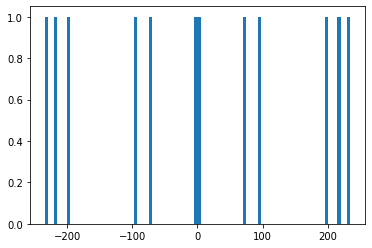

In [71]:
plt.hist([i for i in histPoints if abs(i) < 250],bins=100)

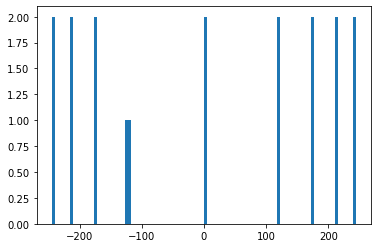

In [48]:
plt.hist([i for i in histPoints if abs(i) < 250],bins=100)
plt.savefig('19_20_test.pdf')